# Lungs assisted with mechanical ventilation: Volume-controlled ventilation (VCV) mode.


In the following notebook we simulate a VCV example using the approach proposal in Hurtado, Avilés-Rojas & Concha (2023).  To this end, a poromechanical multiscale model that connects key alveolar features with organ-level function was developed. In this approach, the coarse-scale problem is informed using a tetrakaidecahedron micromechanical model for the alveolar response at the fine scale that strongly depends on the alveolar-wall elastic modulus and the initial alveolar porosity



The lung is represented by a poroelastic continuum $Ω_X$ with boundary $\partial \Omega_X$. The boundary of the lung domain was partitioned into the airways surface and the
visceral pleura surface that lines the remaining lung surface. The airways boundary was
determined by considering the surface encompassing bifurcations from the mediastinal sur-
face down to the lobar bronchi. Smaller airways in subsequent branches were considered
to be part of the lung parenchyma domain. The visceral pleura surface was defined as the
complement of the airways surface.

The strong formulation for the finite strain poroelasticity problem is

Find $\varphi^c:\Omega_X \times \mathbb{R} \to \mathbb{R}^3$ and $P^c:\Omega_X \times \mathbb{R} \to \mathbb{R}$ such that

\begin{align}
	 \nabla_X \cdot  	 \boldsymbol{P}_S^{eff} &= \boldsymbol{0} &\quad \mbox{ in $\Omega_X \times (0,T]$ } \\
	 \dfrac{\partial \Phi}{\partial t} +\nabla_X \cdot {Q}^c &=0 &\quad \mbox{ in $\Omega_X \times (0,T]$ } . \\
	  \varphi^c &= {{ \varphi}_0^c} &\quad \mbox{ in $\partial \Omega_X$}.  \\
	 P^c &=  P_0^c &\quad \mbox{ on $\partial \Omega_X$}.\\
 \varphi^c &= {{\bar \varphi}^c} &\quad \mbox{ on $\partial \Omega_X^{\varphi}$} \times (0,T] .\\
	 \boldsymbol{P}_S^{eff}  \cdot  \boldsymbol{N} &= {\bar T}^{c} &\quad \mbox{ on $\partial \Omega_X^T$} \times (0,T] . \\
 P^c &= \bar P^c &\quad \mbox{ on $\partial \Omega_X^P$}\times (0,T] \\
\boldsymbol{Q}^c \cdot \boldsymbol{N} &= {\bar Q}^c &\quad \mbox{ on $\partial \Omega_X^Q$} \times (0,T]
\end{align}


where 

\begin{equation}
\boldsymbol{P_S}^{eff} = \boldsymbol{P}_S^{c} - J^c P^c \left(\boldsymbol{F^c}\right)^{-T}
\end{equation}


\begin{equation}
 \boldsymbol{Q}^c=    J^c \boldsymbol{ F}^{c^{-1}}  \boldsymbol{K}  \boldsymbol{F}^{c^{-T}} \nabla_X P^c.  
\end{equation}

We remark that the coarse-scale is informed by the TKD microestructure, then coarse-scale solid stress is computed as

\begin{equation}
    \boldsymbol{P}_S^{c}= \frac{1}{\| \Theta_{Y} \|} \int_{\Theta_{Y_S}}   \boldsymbol{P}_S^{f} \ d \Theta_{Y_S}
\end{equation}
where $\Theta_{Y_S}$ is the solid microestructural (TKDr) domain.





We begin by importing the necessary modules.

In [ ]:
# Import and install 
try:
    import dolfin
    print("oui")
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
!pip install meshio==4.4.6

In [ ]:
import dolfin
import ufl
from petsc4py import PETSc
import userTKD as userTKD
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import modelfunctions as md
from sklearn import linear_model

## Parameters definition


  We define parameters for the simulation:
* TKD parameters:
    + Alveolar-wall elastic modulus $\mu$   (variable to sensitize, baseline=10.33)
    + Initial alveolar porosity $f_0$ (variable to sensitize, baseline=0.69)
    + Rotational stiffness coefficient $\alpha$ (default=1.6)
    + Overlap coefficient $d$ (default=0.49)
* Lung permeability (default=$10^4$)
* Spring stiffness (chest-wall effect) (default=80/1000)
* Ventilator protocol (VCV):
   + PEEP (minimum pressure assumed equal to zero)
   + Times: 
    - Inspiration (default=1)
    - End-inspiratory pause (default=0.25)
    - Expiration (default=2)
   + Volume in each step  (default=250 ml each lung)
   + Number of cycles (default=1)

In [ ]:
alpha = 1.6
d   = 0.49    
fo=0.69
mu=10.33
s0=0
generate_VTK=True
lungs=['Left','Right',]
permeability=dolfin.Constant(pow( 10, 4.0))
Kresorte=80/1000 
Tsyr=1 #tiempo de insuflación
Texp=2
Tpausa=0.25 #duracion de pausa ########mod
Tinsp=Tsyr+Tpausa
duration_step=Tsyr+Tpausa+Texp
vol_step=2.5*100000 #mm*mm*mm ==250 ml
Nciclos=1
ventilation_params=[Tsyr,Texp,Tpausa,vol_step,Nciclos]

## Weak formulation
To solve the problem, it is necessary to state the weak formulation. For the momentum balance equation we get the subproblem
Find ${\varphi}^c \in \mathcal{S}_{\varphi^c}$ and $P^c \in \mathcal{S}_{P^c}$ such that
\begin{equation}
	\int_{\Omega_X} \boldsymbol{P}_S^{c} :  \nabla_X \eta^c  \ d \Omega_X 
	- \int_{\Omega_X}\left( J^c P^c \left(\boldsymbol{F^c}\right)^{-T} \right): \nabla_X {\eta}^c  \ d \Omega_X  -\int_{\partial \Omega_X}   T_S^c \cdot {\eta}^c  \ d \partial \Omega_X=0,
\end{equation}
for any $ \eta^c \in \mathcal{V}_{\varphi^c}$. For the case of the fluid coarse-scale problem, the weak equation is
\begin{equation}
	\int_{\Omega_X}\frac{\partial \Phi}{\partial t} q^c  \ d \Omega_X   - \int_{\Omega_X}   \boldsymbol{Q}^c  \cdot \nabla_X \  q^c \ d \Omega_X +
	\int_{\partial \Omega_X} \bar{Q}^c q^c\ d \partial \Omega_X =0
\end{equation} 
for any $q^c \in \mathcal{V}_{P^c}$.



To simulate this ventilation mode, we consider that the $\text{V}_\text{tidal}$ is supplied during the inspiratory phase by a constant prescribed airflow condition as
$$ \bar{Q}^c=\frac{\text{V}_\text{tidal}}{\text{A}_\text{aw} \  \text{T}_\text{ins}} $$
where $\text{T}_\text{insp}$ is the duration of inspiration and $\text{A}_\text{aw}$ is the area of the airways boundary obtained as the surface integral over this boundary. Then, null airflow is imposed as $\bar{Q}^c=0$ during the end-inspiratory pause. Passive expiration was simulated by prescribing $\bar{P}^c=0$ on the airways boundary, similar to the PCV simulation.

## Solve the problem


Next, the problem is solved using finite elements in FEniCS, for which the following steps are performed:
* Load the mesh and boundaryes
* Build function space. We use Taylor-Hood element
* Initialize solver 
* Time-stepping loop

In [ ]:


#####################################################################################
dolfin.PETScOptions.clear()
quadrature_degree = 2
dolfin.parameters["form_compiler"]["quadrature_degree"]=quadrature_degree
dolfin.parameters['form_compiler']['cpp_optimize'] = True
dolfin.parameters['form_compiler']['representation'] = "uflacs"

for lung in lungs:
    s0=-1*abs(s0)
    caso='fo'+str(round(fo,2))+'_'+'mu'+str(round(mu,2))+'s0'+str(abs(s0))
    print('----INICIO----------------------------------------------')
    print(caso)
    print('--------------------------------------------------')
    md.create_folders(lung,caso) 
    
    quadrature_degree = 2
    dolfin.parameters["form_compiler"]["quadrature_degree"]=quadrature_degree
    dolfin.parameters['form_compiler']['cpp_optimize'] = True
    dolfin.parameters['form_compiler']['representation'] = "uflacs"
    
    # Create Results directory
    dirName = lung+'/'+'Results/'
    try:
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")
        
        
    wdir=lung+'/'
    mesh_path = wdir+'Mesh/'#'Mesh/'
    results_path  = wdir+'Results/'#'Results/'
    
    # prestress
    prestress_target = s0
    prestress_multipliers = np.array([0.5,1.])
    prestress = dolfin.Constant(prestress_target)
    
    # =============================================================================
    # MESH
    # =============================================================================
    
    mesh = dolfin.Mesh()
    hdf = dolfin.HDF5File(mesh.mpi_comm(), mesh_path + 'mesh.h5', "r")
    hdf.read(mesh, "/mesh", False)
    
    boundary_markers = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    hdf.read(boundary_markers, "/boundary_markers")
    hdf.close()
    

    # =============================================================================
    # ELEMENTS AND FUNCTION SPACES
    # =============================================================================
    
    P2 = dolfin.VectorElement("CG", mesh.ufl_cell(), 2)
    P1 = dolfin.FiniteElement("CG", mesh.ufl_cell(), 1)
    TH = dolfin.MixedElement([P2, P1]) 
    W  = dolfin.FunctionSpace(mesh, TH)
    
    # define other spaces
    Efs = dolfin.FunctionSpace(mesh, 'CG', 1)
    Vfs = dolfin.VectorFunctionSpace(mesh, 'CG', 1)
    Tfs = dolfin.TensorFunctionSpace(mesh, 'CG', 1)
    
    #set functions
    dw      = dolfin.TrialFunction(W)
    delta_w = dolfin.TestFunction(W)           
    w       = dolfin.Function(W)  
    
    (du, dp) = dolfin.split(dw)
    (delta_u, delta_p) = dolfin.split(delta_w)
    (u, p) = dolfin.split(w)
    
    
    w0       = dolfin.Function(W)  
    (u0, p0) = dolfin.split(w0)
    
    #Define an expression to time step
    dt = dolfin.Expression(("beta"), beta=0., degree=2, domain=mesh) 
    
    
    # =============================================================================
    # SET BOUNDARY CONDITIONS
    # =============================================================================
    
    zero = dolfin.Constant(0)
    zero_vec = dolfin.Constant((0.0,0.0,0.0))
    p_value = dolfin.Expression(("presiones"),degree=2,domain=mesh,presiones=0.0)
    
    dbc_ufixed = dolfin.DirichletBC(W.sub(0), zero_vec, boundary_markers, 1)
    dbc_p = dolfin.DirichletBC(W.sub(1), p_value, boundary_markers, 1)
    DBC = [ ]
    DBCB=[dbc_p]
    
    
    # =============================================================================
    # WEAK FORMULATION
    # =============================================================================
    
    # deformation
    I  = dolfin.Identity(3)
    grad_phi = dolfin.grad(u) + I
    J  = dolfin.det(grad_phi)
    
    grad_phi0 = dolfin.grad(u0) + I
    J0  = dolfin.det(grad_phi0)
    
    # permeability tensor
    K = dolfin.Identity(3)*permeability
    
    # domains
    dx = dolfin.dx(degree=quadrature_degree)
    ds = dolfin.Measure('ds', domain=mesh, subdomain_data=boundary_markers)(degree=2)
    
    # material parameters
    params = {'mu':dolfin.Constant(mu),
              'fo':dolfin.Constant(fo),
              'd':dolfin.Constant(d),
              'alpha':dolfin.Constant(alpha),
              'K':K}
    
 
    # right hand side
    areas_pres=dolfin.Constant(1)*ds(1)
    L1=-1*(dolfin.inner(u,delta_u)*Kresorte*dolfin.ds(subdomain_data=boundary_markers,subdomain_id=1) \
          +dolfin.inner(u,delta_u)*Kresorte*dolfin.ds(subdomain_data=boundary_markers,subdomain_id=2))# \

    
    dt = dolfin.Expression(("beta"), beta=0., degree=2, domain=mesh) 
    Qbarra = dolfin.Expression(("Qba"), Qba=0,degree=2, domain=mesh)
    L2= -dt*(dolfin.inner(Qbarra, delta_p))*dolfin.ds(subdomain_data=boundary_markers,subdomain_id=1)
    L=L1+L2
    
    NLproblem = md.TKD_NonlinerProblem_poroelastic(rhs=L, bcs=DBC,w0=w0,dt=dt, w=w, dw=dw, delta_w=delta_w, 
                                                       dX=dx, mesh=mesh, degreeF=1, degreeP=1,
                                                       quadrature=quadrature_degree, 
                                                       prestress=prestress, **params)
    
    LB=L1
    NLproblemB = md.TKD_NonlinerProblem_poroelastic(rhs=LB, bcs=DBCB,w0=w0,dt=dt, w=w, dw=dw, delta_w=delta_w, 
                                                       dX=dx, mesh=mesh, degreeF=1, degreeP=1,
                                                       quadrature=quadrature_degree, 
                                                       prestress=prestress, **params)   
    # =============================================================================
    # SOLVER 
    # =============================================================================
    
    # prepare solver
    solver = md.MyNewtonSolver(mesh)
    solver.parameters['convergence_criterion'] = 'residual'
    solver.parameters['relative_tolerance']    = 1E-6#6
    solver.parameters['absolute_tolerance']    = 1E-7#7
    solver.parameters['maximum_iterations']    = 16
    solver.parameters['report']                = True
    solver.parameters['relaxation_parameter']  = 1.0
    solver.parameters['error_on_nonconvergence'] = False
    solver.parameters['linear_solver']         = 'mumps' #'lu'
    
    solverB = md.MyNewtonSolver(mesh)
    solverB.parameters['convergence_criterion'] = 'residual'
    solverB.parameters['relative_tolerance']    = 1E-6 #6
    solverB.parameters['absolute_tolerance']    = 1E-7 #7
    solverB.parameters['maximum_iterations']    = 16
    solverB.parameters['report']                = True
    solverB.parameters['relaxation_parameter']  = 1.0
    solverB.parameters['error_on_nonconvergence'] = False
    solverB.parameters['linear_solver']         = 'mumps' #'lu'
    
    
        
    # =============================================================================
    # SOLUTION
    # =============================================================================
    t1 = time.time()
    print('Solution process started')
    # About hd5file to save data in fenics format -------------------------    
    h5_file = dolfin.HDF5File(mesh.mpi_comm(), results_path + 'model_outputs.h5', "w")
    h5_file.write(mesh, 'mesh')
    
    file_info = open('Information.log','w+')        
    if dolfin.MPI.rank(dolfin.MPI.comm_world) == 0:
        file_info.write('Solution procedure \n')  
        file_info.flush() 
        
    # Time-stepping loop
    areas=dolfin.Constant(1)*ds(1)
    area=dolfin.assemble(areas) 
    times,qs,dts=md.give_times_fluxes_deltas_VCV(Nciclos, vol_step,area,Tsyr,Texp,Tpausa,Tinsp)
    t = 0
    Jacob=[]
    fluxes=[]
    presionestodas=[] 
    
    #1- SOLUTION PRESTRESS- ###################
    file_info.write('Prestress: \n')        
    file_info.flush()
    steps = prestress_multipliers  
    #if presstress==0
    if s0!=0:
        for i, mult in enumerate(steps):
            dt.beta=-1
            # messages
            if dolfin.MPI.rank(dolfin.MPI.comm_world) == 0:
                print('Solving prestress step '+str(i)+' ...')
            # update prestress value
            prestress.assign(prestress_target * mult)
            p_value.presiones=0.0
            print('PRESSURE DURING PRSTRESS',p_value.presiones)
            # run fenics solver 
            w0.assign(w)
            it, conv = solver.solve(NLproblem, w.vector())
            # Extract solution components
            u, p = w.split()
            if dolfin.MPI.rank(dolfin.MPI.comm_world) == 0:
                file_info.write('Step '+str(i)+ ' has converged in '+str(it)+' iterations \n')        
                file_info.flush()
  
    # 2- SOLUTION MECHANICAL VENTILATION ##########################
    #for i, mult in enumerate(steps):
    for i in np.arange(len(times)):
        # messages
        if dolfin.MPI.rank(dolfin.MPI.comm_world) == 0:
            print('Solving step '+str(i)+' ...')
        t=times[i]
        dtt=dts[i]
        Qbarra.Qba=qs[i]
        dt.beta=dtt
    
        # run fenics solver 
        w0.assign(w)
        if t<=Tinsp: #FIN  DE INSPIRACION (INSUFLACION + PAUSA)
            it,conv= solver.solve(NLproblem, w.vector())
        elif Tinsp<t<=duration_step:
            it,conv= solverB.solve(NLproblemB, w.vector())
        elif duration_step<t<duration_step+Tinsp:
          it,conv= solver.solve(NLproblem, w.vector())
        else:
          it,conv= solverB.solve(NLproblemB, w.vector())
                  
        # Extract solution components
        u, p = w.split()
        u.rename("u", "displacement")
        p.rename("p", "pressure")
        if dolfin.MPI.rank(dolfin.MPI.comm_world) == 0:
            file_info.write('Step '+str(i)+ ' has converged in '+str(it)+' iterations \n')        
            file_info.flush()
        
        
        # get pressure (average)   , get volume and flux    
        area_pres=dolfin.assemble(areas_pres)
        paw_avg=  p*dolfin.ds(subdomain_data=boundary_markers,subdomain_id=1)#/area_pres#
        paw=dolfin.assemble(paw_avg)/area_pres
        Vi = dolfin.assemble(J*dx)
        Jacob.append(Vi/1000000)
        deltavol=dolfin.assemble(((J-J0)/dt)*dx)
        fluxes.append(deltavol*10**-6)
        presionestodas.append(paw)
         
        #Save Signals and VTK
        np.save(lung+'/'+'Results/Signals/'+caso+'/multi'+'tiempos.npy',times[0:i+1])
        np.save(lung+'/'+'Results/Signals/'+caso+'/multi'+'fluxes.npy',fluxes)
        np.save(lung+'/'+'Results/Signals/'+caso+'/multi'+'presionestodas.npy',presionestodas)
        np.save(lung+'/'+'Results/Signals/'+caso+'/multi'+'volumenes.npy',Jacob)
        signal_list=[times,fluxes,presionestodas,Jacob]
        if generate_VTK==True:
            md.give_VTKfiles(lung,mesh,signal_list,h5_file,NLproblem,NLproblemB,permeability,ventilation_params,caso,u,p,dx,i,t)
        
    print('FINAL')
    print('------------------------------------------------')
    print('tiempos:',times[0:i+1])
    print('------------------------------------------------')
    print('flujos:',fluxes)
    print('------------------------------------------------')
    print('presiones:',presionestodas)
    print('------------------------------------------------')
    print('volumenes:',Jacob)
    print('------------------------------------------------')

    print(caso)
    print('--------------------------------------------------')    
    h5_file.close()
    t2 = time.time()
    print('Solution process done')
    print('Elapsed time '+str(round(t2-t1,0)))
    

## Plots the ventilator signals

Finally, we plot the ventilator signals for the baseline case.


Baseline


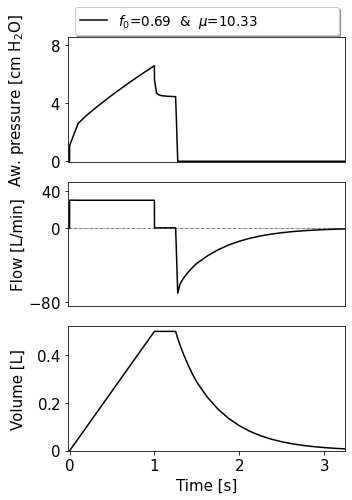

<Figure size 432x288 with 0 Axes>

In [2]:
md.plotbaselineVCV()

We also plot signals for sensitibility analysis of $f_0$ and $\mu$.

**Note: these plots are the results of a sensitibity analysis for f0 and mu. To did these plots, all case must been ran:**


`fos=[1.2*0.69, 0.8*0.69,  0.69 , 1.05*0.69,  0.95*0.69]`

`mus=[1.2*10.33,0.8*10.33, 0.95*10.33, 10.33,1.05*10.33]`

Sensitibity analysis for f0


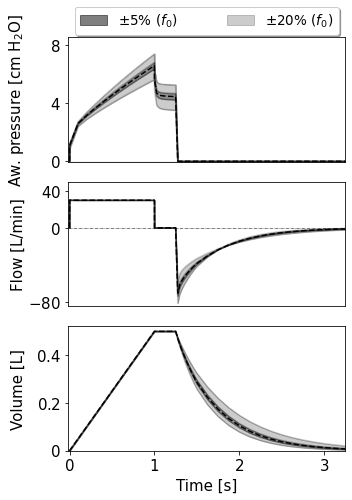

---------------------------------------------------------------
Sensitibity analysis for \mu


<Figure size 432x288 with 0 Axes>

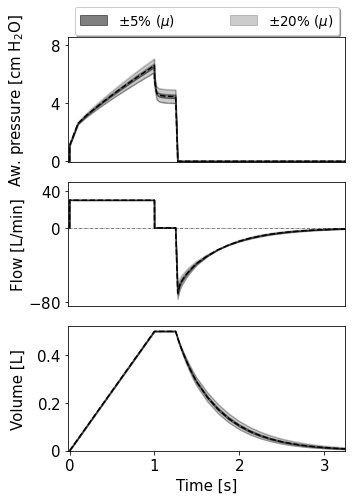

<Figure size 432x288 with 0 Axes>

In [2]:
md.plotVCV()